In [2]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import dataloader
import os
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from scipy.special import softmax

from action_utils import *

## Generate my new spatial_video_preds.pickle by old rgb model

In [4]:
def stack_op(imgs_u,imgs_v,i):
    _, img_rows, img_cols = imgs_u[0].shape
    flow = torch.FloatTensor(2*10,img_rows,img_cols)

    for j in range(i, 10+i):
        H = imgs_u[j]
        V = imgs_v[j]

        flow[2*(j-1-i),:,:] = H
        flow[2*(j-1-i)+1,:,:] = V

    flow = flow.unsqueeze(0)
    
    return flow

In [5]:
from two_stream_loader import *

In [6]:
path_temporal = r"/mnt/disks/datastorage/videos/flownet2/"
path_spatial = r"/mnt/disks/datastorage/videos/rgb/"

In [7]:
frame_count = dataloader.frame_count

In [8]:
dic_testing = {}
for key,value in test_video.items():
    dic_testing[key+" "+str(frame_count[key]-10+1)] = value

In [9]:
[temporal_net,spatial_net] =load_models("","")

Dropout is  0
Dropout is  0


In [10]:
nSamples = 30
spatial_net.eval()
temporal_net.eval()


rgb_dic={}
opf_dic={}
for key,value in dic_testing.items():
    video_name,nb_frames = key.split(' ')
    nb_frames = int(nb_frames)
    
    try:
        imgs_u,imgs_v = load_temporal_images(path_temporal,"v_"+video_name)
        imgs_spatial = load_spatial_images(path_spatial,"v_"+video_name)
    except:
        print("Skipped ",video_name)
        continue
    
#     print(video_name,nb_frames)
    p_spatial = np.zeros((1,4))
    p_temporal = np.zeros((1,4))
    for i in range(nSamples):
#         print(i*nb_frames/nSamples,(i+1)*nb_frames/nSamples)
#         print(np.random.randint(i*nb_frames/nSamples,(i+1)*nb_frames/nSamples))
        idx = np.random.randint(i*nb_frames/nSamples,(i+1)*nb_frames/nSamples)

        p_spatial = spatial_net.forward(imgs_spatial[idx].unsqueeze(0).cuda()).cpu().detach().numpy().squeeze()
        p_spatial += p_spatial
        
        flow = stack_op(imgs_u,imgs_v,idx)
        p_temporal = temporal_net.forward(flow.cuda()).cpu().detach().numpy().squeeze()
        p_temporal += p_temporal
    
    rgb_dic[video_name] = softmax(p_spatial)
    opf_dic[video_name] = softmax(p_temporal)
    
    

In [11]:
rgb_d='record/spatial/spatial_video_preds.pickle'
with open(rgb_d,'wb') as f:
    pickle.dump(rgb_dic,f)

In [12]:
opf_d='record/motion/motion_video_preds.pickle'
with open(opf_d,'wb') as f:
    pickle.dump(opf_dic,f)

## Confusion Time

In [13]:
rgb_preds='record/spatial/spatial_video_preds.pickle'
with open(rgb_preds,'rb') as f:
    rgb =pickle.load(f)
    
opf_preds = 'record/motion/motion_video_preds.pickle'
with open(opf_preds,'rb') as f:
    opf =pickle.load(f)
    
stream = opf

In [14]:
dataloader = dataloader.spatial_dataloader(BATCH_SIZE=1, num_workers=1, 
                                           path='/mnt/disks/datastorage/videos/rgb/', 
                                           ucf_list='/home/mlp/two-stream-action-recognition/UCF_list/',
                                           ucf_split='01')
train_loader,val_loader,test_video = dataloader.run()

AttributeError: 'spatial_dataloader' object has no attribute 'spatial_dataloader'

In [15]:
num_classes = 4

In [16]:
video_level_argmax = np.zeros(len(stream.keys()))
video_level_labels = np.zeros(len(stream.keys()))
video_level_preds = np.zeros((len(rgb.keys()), num_classes))

video_level_rgb_preds = np.zeros((len(rgb.keys()), num_classes))
video_level_op_preds = np.zeros((len(rgb.keys()), num_classes))
video_level_op_argmax = np.zeros(len(stream.keys()))
video_level_rgb_argmax = np.zeros(len(stream.keys()))


for ii, name in enumerate(sorted(stream.keys())):
    r = rgb[name]
    o = opf[name]

    label = int(test_video[name])-1

    fusion = r + o
    video_level_preds[ii,:] = fusion
    video_level_argmax[ii] = np.argmax(fusion)
    video_level_labels[ii] = label
    
    video_level_op_preds[ii,:] = o
    video_level_rgb_preds[ii,:] = r

    video_level_op_argmax[ii] = np.argmax(o)
    video_level_rgb_argmax[ii] = np.argmax(r)

    
video_level_argmax = video_level_argmax.astype(np.uint8)
video_level_op_argmax = video_level_op_argmax.astype(np.uint8)
video_level_rgb_argmax = video_level_rgb_argmax.astype(np.uint8)

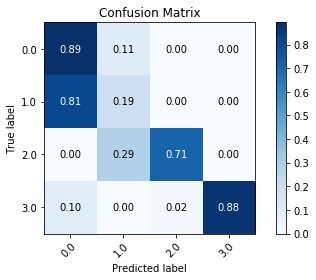

In [20]:
classes = set(video_level_labels.tolist() + video_level_argmax.tolist())
assert len(classes) == num_classes

cm = confusion_matrix(video_level_labels, video_level_argmax)
#cm = confusion_matrix(video_level_labels, video_level_op_argmax)
#cm = confusion_matrix(video_level_labels, video_level_rgb_argmax)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cmap = plt.cm.Blues
title = 'Confusion Matrix'

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

## Exploratory Data Analysis

In [ ]:
idx_assault = video_level_labels==1

In [ ]:
assault_pred_rgb = video_level_rgb_preds[idx_assault,:]

In [ ]:
df = pd.DataFrame({"RGB":assault_pred_rgb[:,1],"OF":assault_pred_of[:,1]})

In [ ]:
df["OF"].hist()

In [ ]:
df["RGB"].hist()

In [ ]:
plt.figure(figsize=(10,10))
sns.jointplot(x="RGB",y="OF",data=df)
plt.show()